## Описание проекта "Телеком"

Оператор связи хочет научиться прогнозировать отток клиентов. По техническому заданию метрика AUC-ROC>0.85, а также дополнительная метрика accuracy

<b> План работы: </b>

1) Загрузить и ознакомиться с данными;

2) Провести первичное ознакомление с данными;

3) Исходя из первичного ознакомления, провести предобработку данных (удаление дубликатов, изменение типов данных, создание целевого признака и др. по необходимости);

4) Проведение EDA, на основе которого, возможно, создание дополнительных признаков на основе имеющихся;

5) Подготовка признаков к моделированию (определение категориальных и числовых признаков), заполнение пропусков, удаление неинформативных признаков;

6) Подготовка тестовой и обучающей выборок (на тест 25% данных);

7) создание пайплайна для подготовки признаков к моделям;

8) Создание моделей, подбор параметров, выбор лучшей по метрике AUC-ROC;

9) Тестирование модели на тестовой выборке с целью получения значения метрики не меньше 0,85;

10) Анализ важности признаков, построение матрицы ошибок;

11) Вывод

## Первичное ознакомление с данными

### Загрузка необходимых библиотек

In [1]:
! pip install phik

In [2]:
! pip install missingno

In [3]:
! pip install catboost

In [4]:
! pip install optuna

In [5]:
! pip install lightgbm

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import missingno as msno

from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostClassifier

import optuna
from optuna.integration import OptunaSearchCV
import lightgbm as lgb

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix

RANDOM_STATE = 220523

In [7]:
contract = pd.read_csv('/datasets/contract_new.csv')
persona = pd.read_csv('/datasets/personal_new.csv')
internet = pd.read_csv('/datasets/internet_new.csv')
phone = pd.read_csv('/datasets/phone_new.csv')

In [8]:
# Создадим функцию для первичного ознакомления с данными
def first_info (data):
    print(' ')
    display(data.sample(7))
    print(' ')
    display(data.info())
    print('Количество дубликатов', data.duplicated().sum())
    print('-----'*20)


### Первичный осмотр данных

#### Информация о договоре

In [9]:
# Рассмотрим датасет contract
first_info(contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
302,8266-VBFQL,2019-10-01,No,Month-to-month,Yes,Electronic check,90.40,390.53
6296,4023-RTIQM,2017-07-01,No,One year,Yes,Credit card (automatic),50.40,1562.4
2670,4531-AUZNK,2015-11-01,No,One year,Yes,Mailed check,95.15,4901.18
3207,3694-GLTJM,2019-09-01,No,Month-to-month,Yes,Credit card (automatic),19.65,98.25
911,7508-SMHXL,2018-11-01,No,Month-to-month,No,Credit card (automatic),89.00,1428.45
6218,8821-KVZKQ,2014-04-01,No,One year,Yes,Bank transfer (automatic),58.40,4496.8
5720,2325-WINES,2017-06-01,No,One year,Yes,Credit card (automatic),104.05,3329.6


 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

Количество дубликатов 0
----------------------------------------------------------------------------------------------------


In [10]:
contract['customerID'].nunique()

7043

Датасет contract представлен 7043 строками - id уникальных пользователей. Названия столбцов не соответствуют змеиному регистру; пропущенных значений нет; в столбце дата окончания есть значение 'no', что означает, что клиент еще не ушел; все столбцы, кроме ежемесячного платежа в формате object. Строки-дубликаты отсутствуют. Видно, что с тип данных столбца "TotalCharges" необходимо будет изменить на float, а признаки с датами в соответствующий тип datetime

#### Персональные данные клиента

In [11]:
# Рассмотрим датасет persona
first_info(persona)

,customerID,gender,SeniorCitizen,Partner,Dependents
5377,8313-KTIHG,Male,0,No,No
298,2985-JUUBZ,Male,0,Yes,Yes
5150,7017-VFULY,Female,0,Yes,No
5226,8044-BGWPI,Male,0,Yes,Yes
4923,6075-QMNRR,Female,0,No,No
4067,9140-CZQZZ,Female,0,Yes,No
1140,9553-DLCLU,Female,0,No,Yes


 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

Количество дубликатов 0
----------------------------------------------------------------------------------------------------


In [12]:
persona['customerID'].nunique()

7043

Датасет persona представлен 7043 строками - id уникальных пользователей. Названия столбцов не соответствуют змеиному регистру; пропущенных значений нет; все столбцы, кроме пенсионного статуса в формате object. Строки-дубликаты отсутствуют. Надо отметить, что пенсионый статус по возрасту - это категориальный признак, надо будет изменить тип данного столбца.

#### Информация об интернет-услугах

In [13]:
# Рассмотрим датасет internet
first_info(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
4055,0786-IVLAW,Fiber optic,No,Yes,Yes,No,Yes,Yes
2301,3352-ALMCK,Fiber optic,No,Yes,Yes,No,Yes,Yes
2056,3336-JORSO,Fiber optic,No,Yes,Yes,Yes,Yes,Yes
4298,5536-SLHPM,Fiber optic,No,No,Yes,No,No,No
759,6680-WKXRZ,Fiber optic,No,No,No,No,No,No
5128,1427-VERSM,Fiber optic,No,No,Yes,Yes,Yes,Yes
4923,5872-OEQNH,DSL,Yes,No,Yes,No,No,Yes


 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

Количество дубликатов 0
----------------------------------------------------------------------------------------------------


In [14]:
internet['customerID'].nunique()

5517

Датасет internet представлен 5517 строками - id уникальных пользователей. Надо отметить, что это меньшее количество, чем в таблице с контрактами, следовательно, не все пользователи подключили интернет. Названия столбцов также не соответствуют змеиному регистру как и впредыдущих датасетах; пропущенных значений нет; все столбцы имеют тип данных object. 

#### Информация об услугах телефонии

In [15]:
# Рассмотрим датасет phone
first_info(phone)

,customerID,MultipleLines
4342,0018-NYROU,No
167,4827-USJHP,No
955,5981-ITEMU,Yes
1432,5014-WUQMG,No
287,7102-JJVTX,No
2622,8148-NLEGT,Yes
5615,8111-RKSPX,Yes


 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

Количество дубликатов 0
----------------------------------------------------------------------------------------------------


In [16]:
phone['customerID'].nunique()

6361

Датасет phone представлен 6361 строками - id уникальных пользователей. Надо отметить, что это меньшее количество, чем в таблице с контрактами, следовательно, не все пользователи имеют стационарную телефонную связь. Названия столбцов также не соответствуют змеиному регистру как и впредыдущих датасетах; пропущенных значений нет; строк-дубликатов нет; столбцы имеют тип данных object. 

Таким образом, первичный осмотр данных определил, что перед более глубоким анализом необходимо:

1) объединить датасеты в один, сохранив все уникальные ID клиентов (кто-то пользуется только интернетом, кто-то только телефоном, кто-то и тем, и тем), ID клиентов будем использовтаь как ключ для объединения таблиц;

2) привести заголовки к змеиному регистру;

3) добавить целевой признак на основе признака end_date;

4) тип данных столбца "TotalCharges" необходимо будет изменить на float;

5) изменить тип данных в столбцах со временем; 

6) пенсионый статус по возрасту - это категориальный признак, надо будет изменить тип данного столбца

#### Объединение таблиц и приведение к змеиному регистру

In [17]:
# установим в качестве индекса в датафреймах уникальные айди пользователей
datas = [contract, persona, internet, phone]
for i in datas:
    i.set_index('customerID', inplace=True)

In [18]:
# Объединим 4 таблицы в одну
df = persona.join([contract, internet, phone], how='left')

In [19]:
# Рассмотрим объединенную таблицу 
first_info(df)

,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7030-FZTFM,Male,0,Yes,Yes,2014-02-01,No,Two year,No,Credit card (automatic),110.90,7984.8,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes
9866-OCCKE,Female,1,Yes,No,2014-02-01,No,Two year,Yes,Mailed check,109.75,7902.0,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Yes
4304-TSPVK,Female,0,Yes,No,2014-06-01,No,Two year,No,Bank transfer (automatic),114.90,8125.73,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
2840-XANRC,Male,1,Yes,No,2017-12-01,No,Month-to-month,Yes,Electronic check,93.15,2421.9,Fiber optic,No,No,Yes,No,Yes,Yes,No
8050-WYBND,Female,0,No,Yes,2018-04-01,2018-10-01,One year,Yes,Credit card (automatic),49.45,314.5,DSL,No,No,Yes,No,Yes,Yes,NaN
1697-NVVGY,Male,1,Yes,No,2018-07-01,No,Month-to-month,No,Bank transfer (automatic),66.40,1299.45,DSL,Yes,No,Yes,No,Yes,No,No
6518-LGAOV,Female,0,Yes,No,2016-09-01,2019-10-01,Month-to-month,Yes,Electronic check,105.00,4040.4,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes


 
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   BeginDate         7043 non-null   object 
 5   EndDate           7043 non-null   object 
 6   Type              7043 non-null   object 
 7   PaperlessBilling  7043 non-null   object 
 8   PaymentMethod     7043 non-null   object 
 9   MonthlyCharges    7043 non-null   float64
 10  TotalCharges      7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-nul

None

Количество дубликатов 4
----------------------------------------------------------------------------------------------------


Мы объединили 4 таблица в одну, в качестве ключа взяли уникальный айди клиента (при объединении информация не потерялась, все 7043 клиента на месте). На данный момент мы имеем 19 признаков; пропущенные значения в столбцах с признаками, относящимся к интернету или телефонии; получилось 4 дубликата - пользоватлели, имеющие одинаковые характеристики, хотя это разные люди, для моделирования лучше удалим их.

In [20]:
# Удалим строки-дубликаты
df = df.drop_duplicates()

Для дальнейшего удобства анализа и моделирования, приведем названия столбцов к змеиному регистру

In [21]:
# сначала приведем названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()
df.columns

Index(['gender', 'seniorcitizen', 'partner', 'dependents', 'begindate',
       'enddate', 'type', 'paperlessbilling', 'paymentmethod',
       'monthlycharges', 'totalcharges', 'internetservice', 'onlinesecurity',
       'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv',
       'streamingmovies', 'multiplelines'],
      dtype='object')

In [22]:
df.columns = ['gender', 'senior_citizen', 'partner', 'dependents', 'begin_date',
       'end_date', 'type', 'paper_less_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'multiple_lines']

#### Создание целевого признака

В столбце "end_date" имеются значения - "no", т.е. клиент не ушел, что соответствует 0, остальные значения - 1 для таргета

In [23]:
y = []
for i in df['end_date']:
    if i == 'No':
        y.append(0)
    else:
        y.append(1)

In [24]:
df['label'] = y

#### Изменение типов данных

При попытке использовать astype(), была ошибка, можем предположить, что в каких-то данных имеются пропущенные значения (не nan), проверим это

In [25]:
df.loc[df['total_charges'] == ' ', 'total_charges'].count()

11

Наше предположение о том, что в данных столбца total_charges имеются не заполненные значения - верно, рассмотрим этих клиентов

In [26]:
df.loc[df['total_charges'] == ' ']

,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paper_less_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,label
customerID,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,Female,0,Yes,Yes,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,DSL,Yes,No,Yes,Yes,Yes,No,NaN,0
3115-CZMZD,Male,0,No,Yes,2020-02-01,No,Two year,No,Mailed check,20.25,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
5709-LVOEQ,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,80.85,,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
4367-NUYAO,Male,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,25.75,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0
1371-DWPAZ,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,0
7644-OMVMY,Male,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,19.85,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
3213-VVOLG,Male,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,25.35,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0
2520-SGTTA,Female,0,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,20.00,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
2923-ARZLG,Male,0,Yes,Yes,2020-02-01,No,One year,Yes,Mailed check,19.70,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0


Клиенты с незаполненным значением total_charges заключили договор в день скачивания анкеты, у всех контракт на 2 года, ежемесячный платеж осуществлен. Можно было бы заполнить пропущенные значения значением ежемесячного платежа, однако, это всего 11 пользователей, которые к тому же, только пришли, и заключили долгосрочный контракт, удалим их, так как информативности при моделировании от них немного (и их незначительное количество)

In [27]:
# Удалим клиентов с пропущенным значением total_charges и изменим тип данных на float64
df = df.loc[df['total_charges'] != ' '].copy()
df['total_charges'] = df['total_charges'].astype('float64')

Для изменения типа данных в столбце end_date - надо заменить значение 'No' на дату скачивания анкеты

In [28]:
df['end_date'] = df['end_date'].replace('No', '2020-02-01')

In [29]:
# Изменим тип данных в столбце end_date на тип даты
df['end_date'] = pd.to_datetime(df['end_date'])

In [30]:
# Изменим тип данных в столбце begin_date на тип даты
df['begin_date'] = pd.to_datetime(df['begin_date'])

In [31]:
# Изменим тип данных в столбце senior_citizen с целочисленного на object
df['senior_citizen'] = df['senior_citizen'].astype('object')

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7028 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   gender              7028 non-null   object        
 1   senior_citizen      7028 non-null   object        
 2   partner             7028 non-null   object        
 3   dependents          7028 non-null   object        
 4   begin_date          7028 non-null   datetime64[ns]
 5   end_date            7028 non-null   datetime64[ns]
 6   type                7028 non-null   object        
 7   paper_less_billing  7028 non-null   object        
 8   payment_method      7028 non-null   object        
 9   monthly_charges     7028 non-null   float64       
 10  total_charges       7028 non-null   float64       
 11  internet_service    5511 non-null   object        
 12  online_security     5511 non-null   object        
 13  online_backup       5511 non-null   ob

Таким образом, мы объединили 4 таблицы в одну, привели заголовки к змеиному регистру, создали целевой признак label, столбцы со временем привели к типу даты, столбец total_charges - к float64

Предварительный осмотр данных на этом закончен. Можно приступать к более детальному анализу признаков, работе с пропущенными значениями и определению признаков для обучения.

## EDA

Рассмотрим каждый признак более детально

На основе матрицы фик-корреляции, можно определить, что признак end_date имеет очень сильную связь с целевым признаком (1). При этом, сила влияния остальных слабая. Кроме того, имеется сильная связь между признаками "monthly_charges" и "internet_service" - 0,95. Чуть менее сильная связь наблюдается между признаками

### Категориальные признаки

In [33]:
col_cat_list = {'Пол':'gender', 'Наличие пенсионного статуса по возрасту':'senior_citizen', 'Наличие супруга(и)':'partner', 'Наличие иждивенцев': 'dependents', 'Тип оплаты':'type',
       'Электронный платежный документ':'paper_less_billing', 'Способ оплаты':'payment_method', 'Интерент (тип соединения)':'internet_service',
       'Блокировка небезопасных сайтов':'online_security', 'Облачное хранилище файлов для резервного копирования данных':'online_backup', 'Антивирус':'device_protection', 'Выделенная линия технической поддержки':'tech_support',
       'Стриминговое телевидение':'streaming_tv', 'Каталог фильмов':'streaming_movies', 'Наличие возможности ведения параллельных линий во время звонка':'multiple_lines'}

Распределение значений по признаку Пол
Male      0.5
Female    0.5
Name: gender, dtype: float64


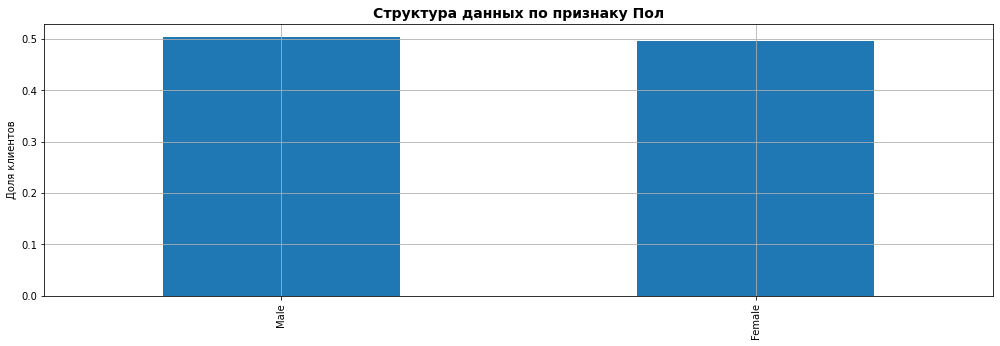

Распределение значений по признаку Наличие пенсионного статуса по возрасту
0    0.84
1    0.16
Name: senior_citizen, dtype: float64


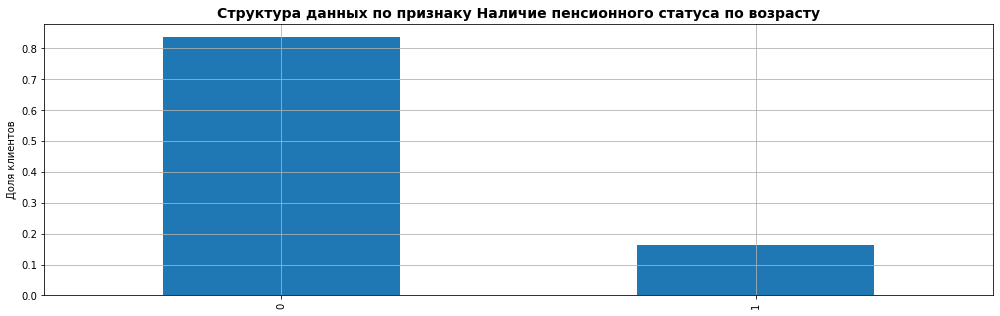

Распределение значений по признаку Наличие супруга(и)
No     0.52
Yes    0.48
Name: partner, dtype: float64


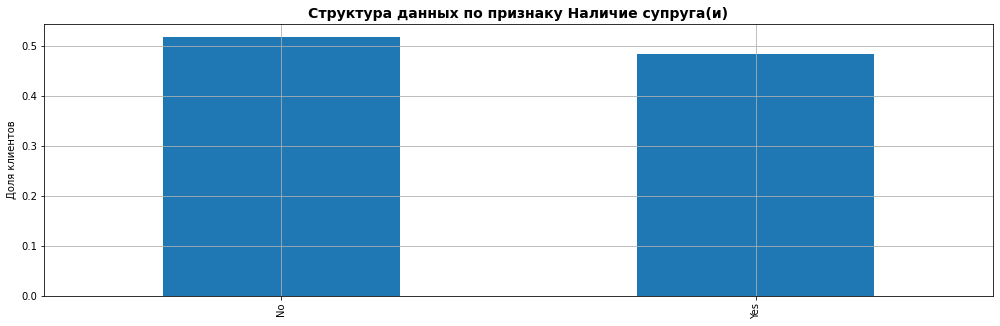

Распределение значений по признаку Наличие иждивенцев
No     0.7
Yes    0.3
Name: dependents, dtype: float64


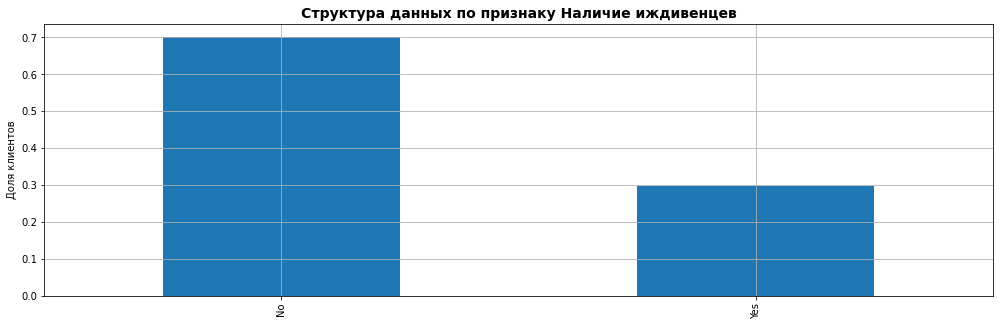

Распределение значений по признаку Тип оплаты
Month-to-month    0.55
Two year          0.24
One year          0.21
Name: type, dtype: float64


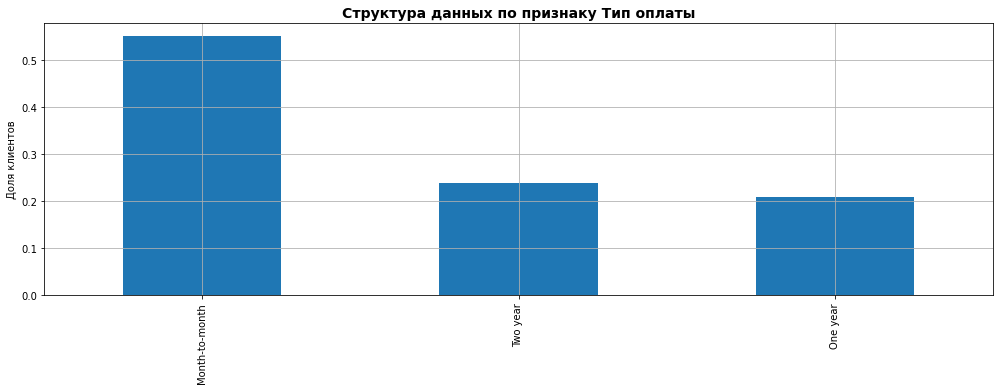

Распределение значений по признаку Электронный платежный документ
Yes    0.59
No     0.41
Name: paper_less_billing, dtype: float64


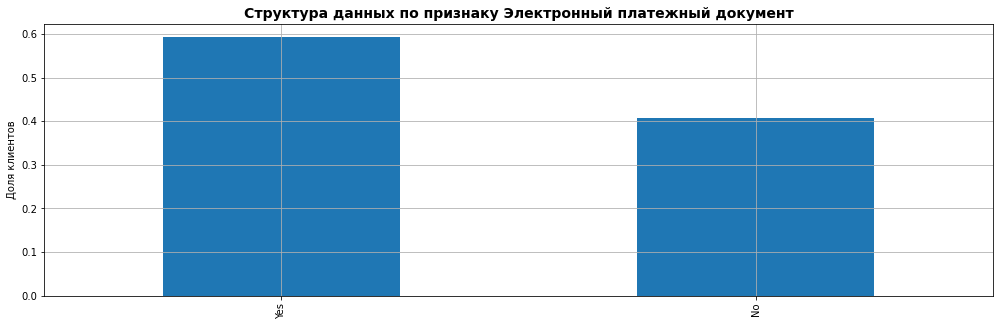

Распределение значений по признаку Способ оплаты
Electronic check             0.34
Mailed check                 0.23
Bank transfer (automatic)    0.22
Credit card (automatic)      0.22
Name: payment_method, dtype: float64


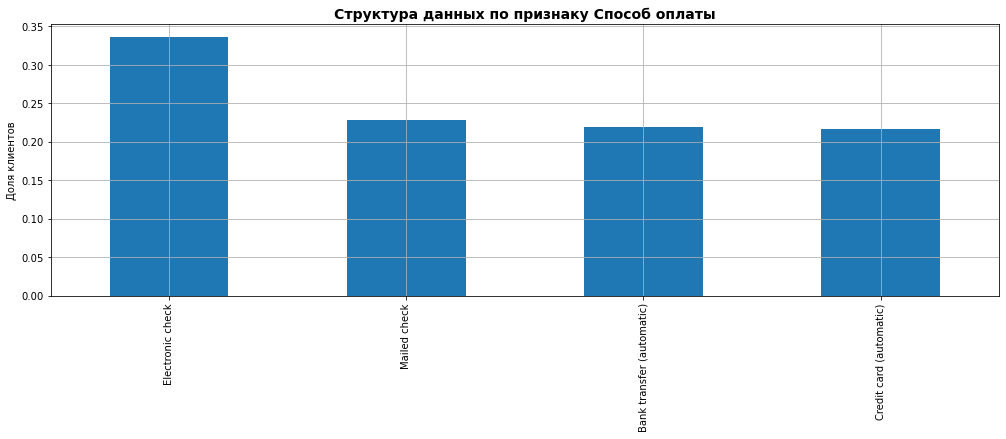

Распределение значений по признаку Интерент (тип соединения)
Fiber optic    0.44
DSL            0.34
NaN            0.22
Name: internet_service, dtype: float64


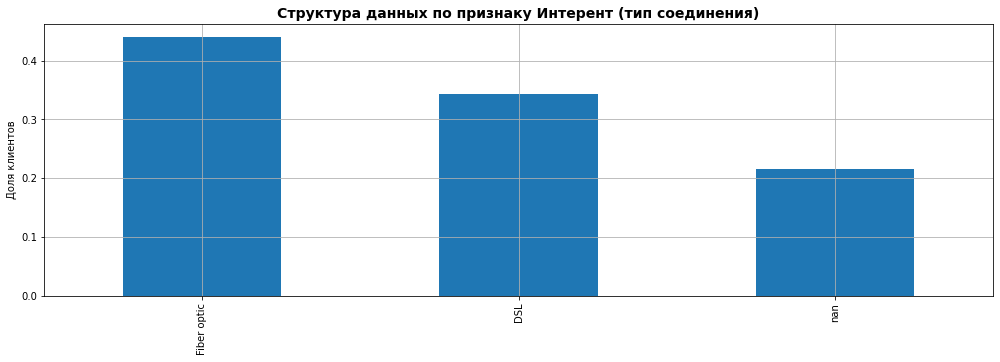

Распределение значений по признаку Блокировка небезопасных сайтов
No     0.50
Yes    0.29
NaN    0.22
Name: online_security, dtype: float64


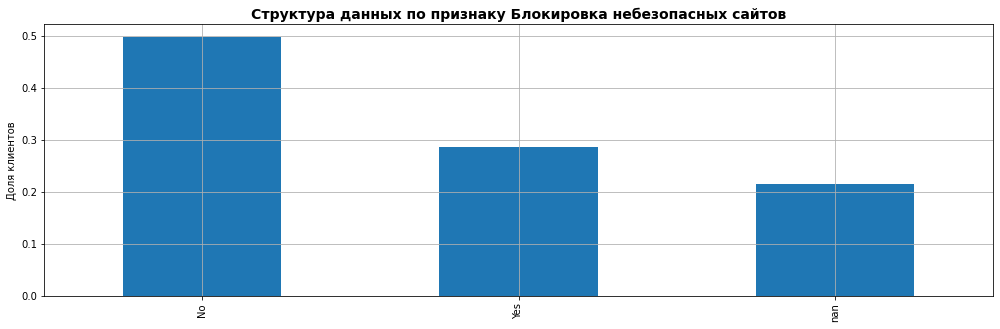

Распределение значений по признаку Облачное хранилище файлов для резервного копирования данных
No     0.44
Yes    0.34
NaN    0.22
Name: online_backup, dtype: float64


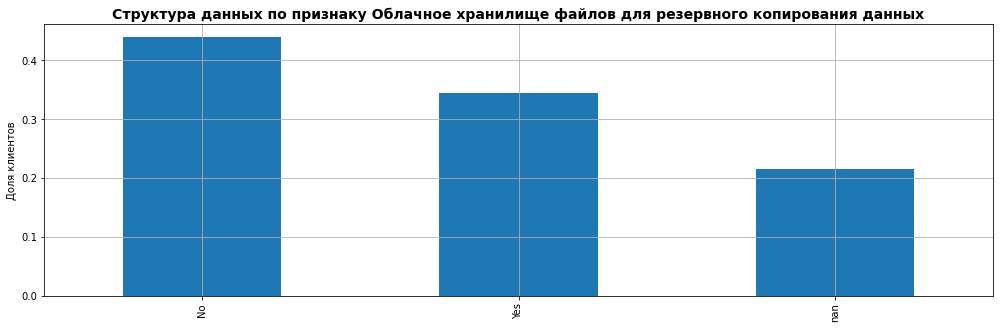

Распределение значений по признаку Антивирус
No     0.44
Yes    0.34
NaN    0.22
Name: device_protection, dtype: float64


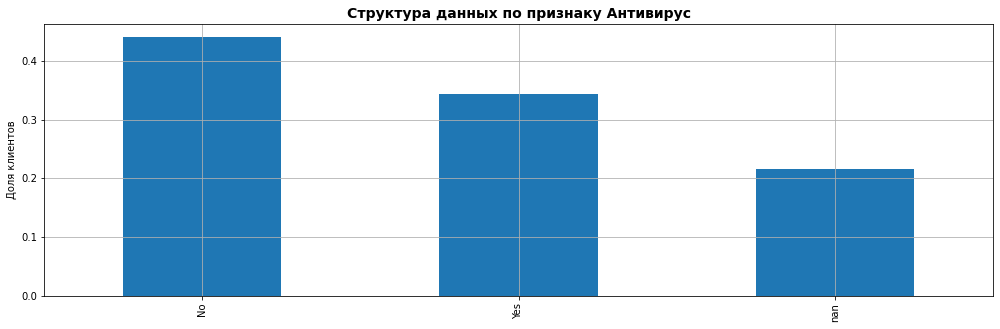

Распределение значений по признаку Выделенная линия технической поддержки
No     0.49
Yes    0.29
NaN    0.22
Name: tech_support, dtype: float64


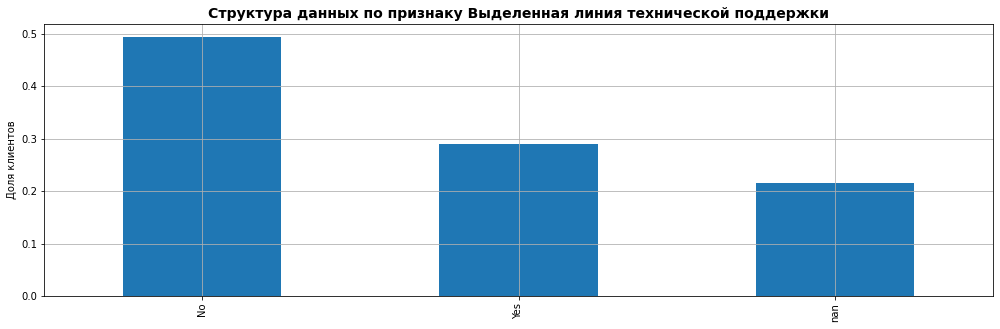

Распределение значений по признаку Стриминговое телевидение
No     0.40
Yes    0.38
NaN    0.22
Name: streaming_tv, dtype: float64


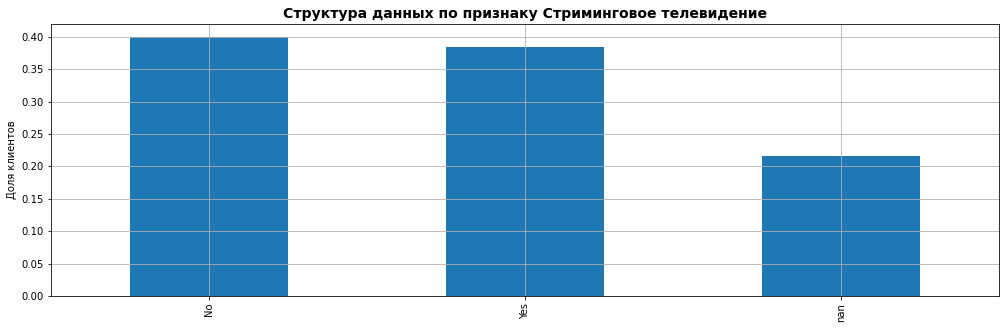

Распределение значений по признаку Каталог фильмов
No     0.40
Yes    0.39
NaN    0.22
Name: streaming_movies, dtype: float64


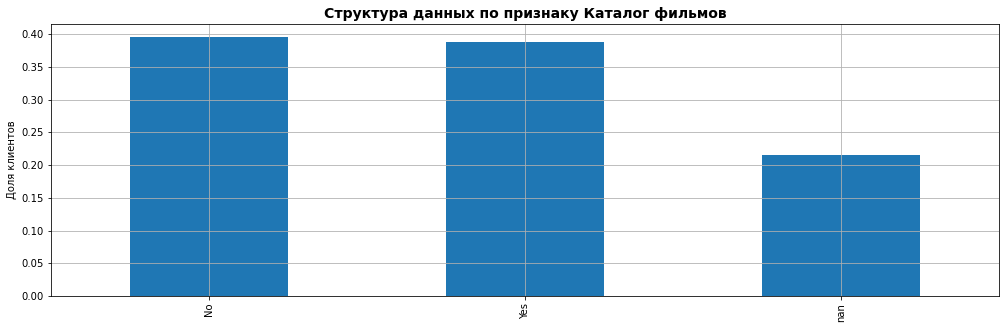

Распределение значений по признаку Наличие возможности ведения параллельных линий во время звонка
No     0.48
Yes    0.42
NaN    0.10
Name: multiple_lines, dtype: float64


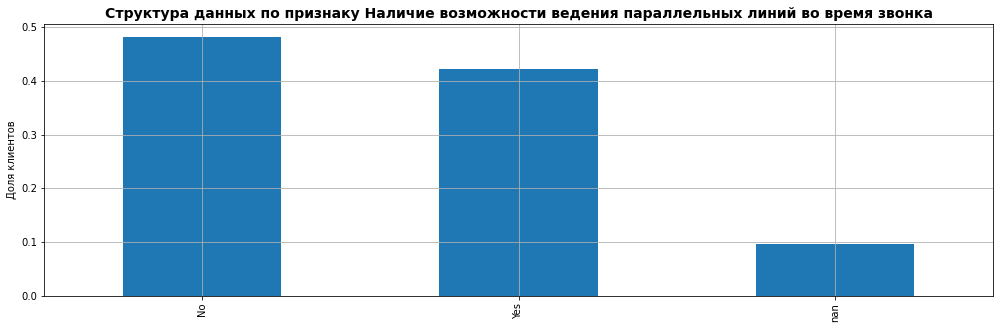

In [34]:
for a, i in col_cat_list.items():
    print(f'Распределение значений по признаку {a}')
    value_counts = df[i].value_counts(normalize=True, dropna=False)
    print(round(value_counts,2))
        
    plt.figure(figsize=(17, 5))
    value_counts.plot(kind='bar', grid=True)
    plt.title(f'Структура данных по признаку {a}', fontdict={'fontsize': 14, 'fontweight': 'bold'})
    plt.ylabel('Доля клиентов')
    plt.show()

Соотношение клиентов-мужчин и женщин практически одинаковое. Около 16% клиентов-пенсионеров; 48% людей имеют супруга(у). Большая часть (70%) клиентов не обременена иждивенцами. 
Более половины (55%) используют ежемесячный тип оплаты, договоры на два года и на год заключают примерно одинаковое количество людей (24% и 21%).
Электронный платежный документ получает 59% клиентов, среди доминирующего способа оплаты можно выделить Electronic check (34%), остальные имеют равную долю (22-23%).
У клиентов, подключивших Интернет (их 78%), преобладающий тип соединения – оптоволокно (44%), услуга по блокировке небезопасных сайтов подключена только у 29% , облачное хранилище данных – у 34%, антивирус – также у 34% .
Выделенную линию техподдержки имеют 29% клиентов, стриминговое телевидение – у 38%, каталог фильмов – у 39% клиентов, наличие ведения параллельных линий во время звонка – у 42%.

In [35]:
data = df.copy()
data = data.fillna('Missing') # чтобы отображались категории с пропущенными значениями, если у них большая доля оттока

Рассмотрим распределение значений в зависимости от таргета

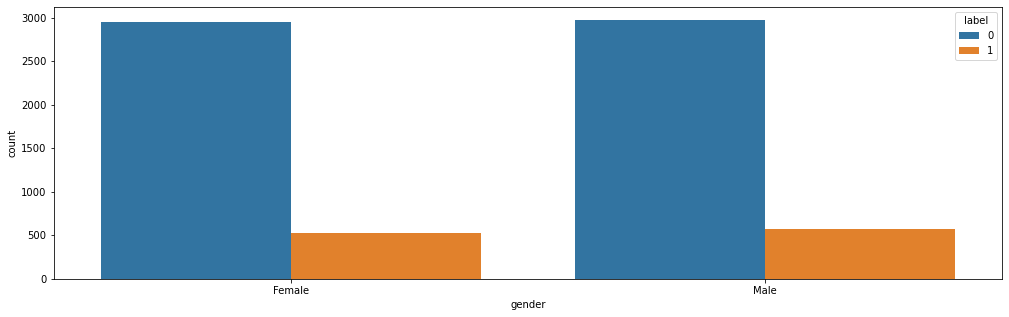

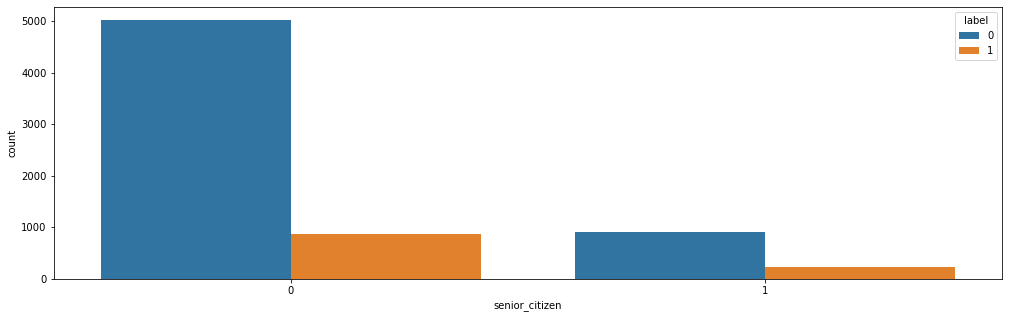

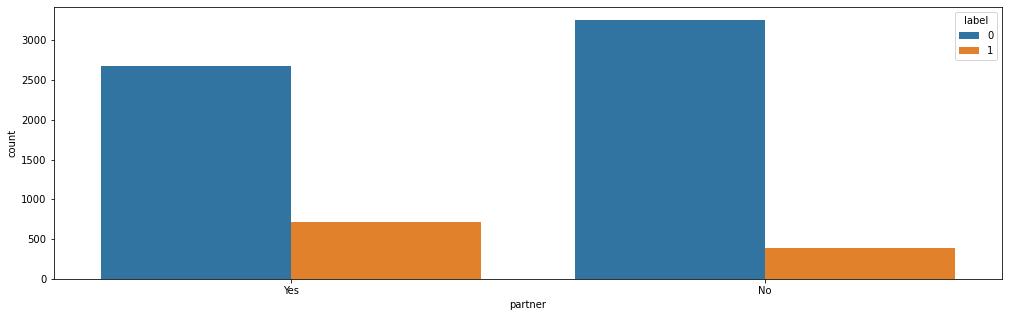

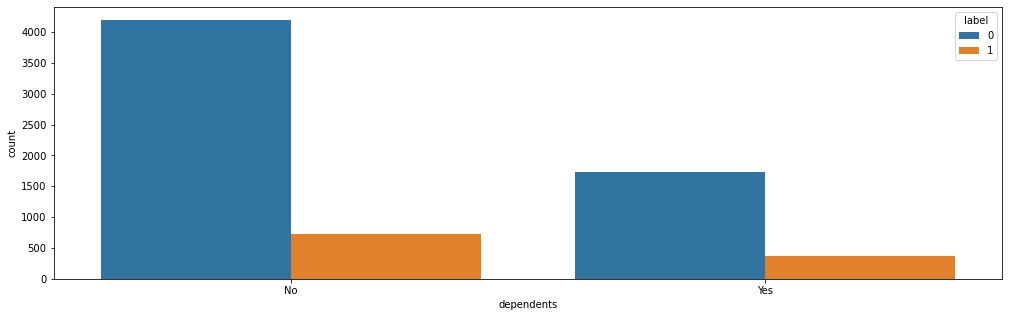

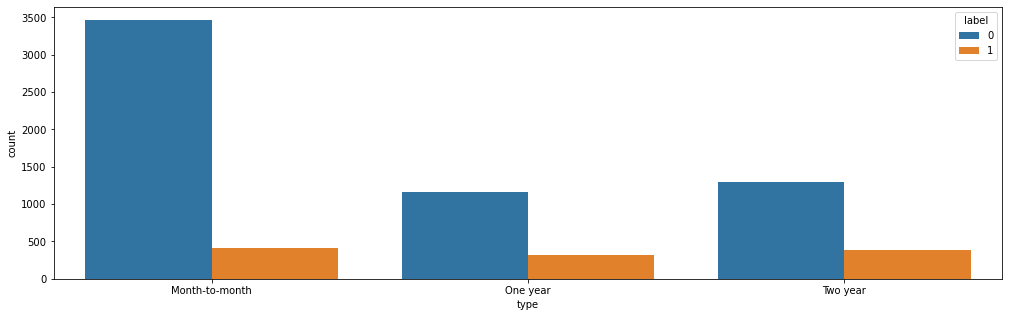

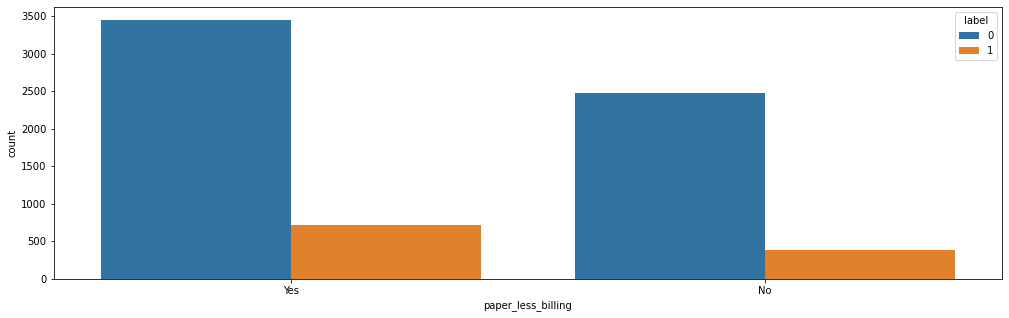

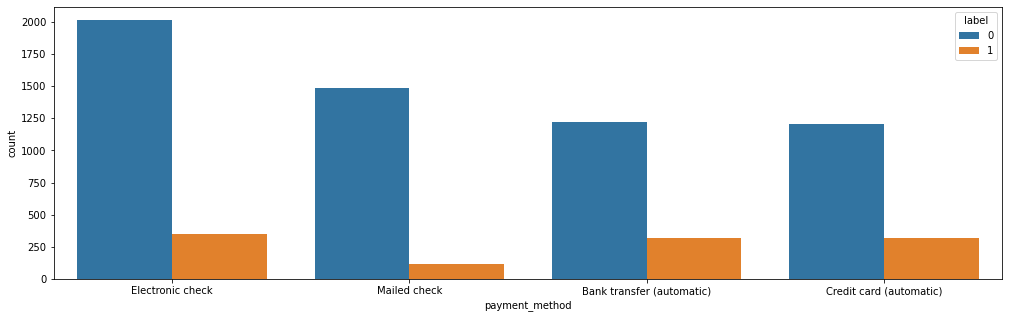

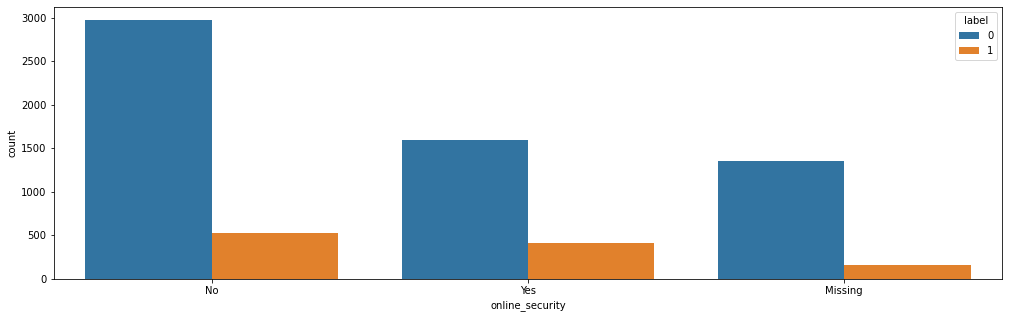

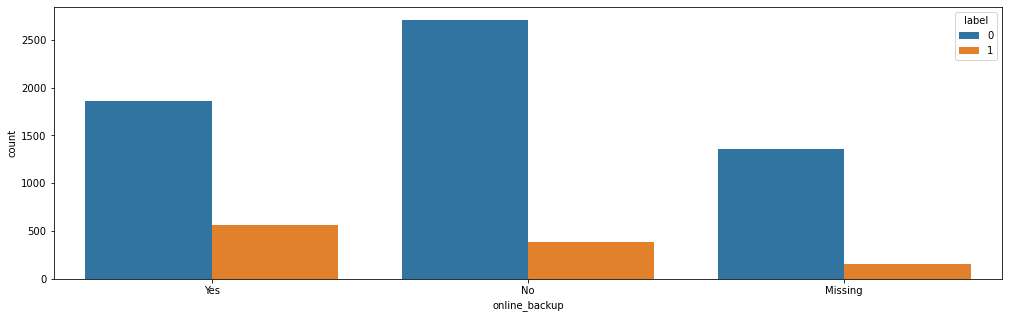

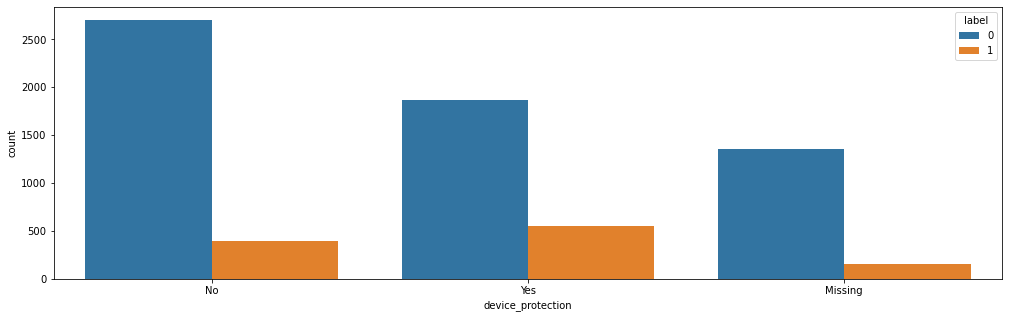

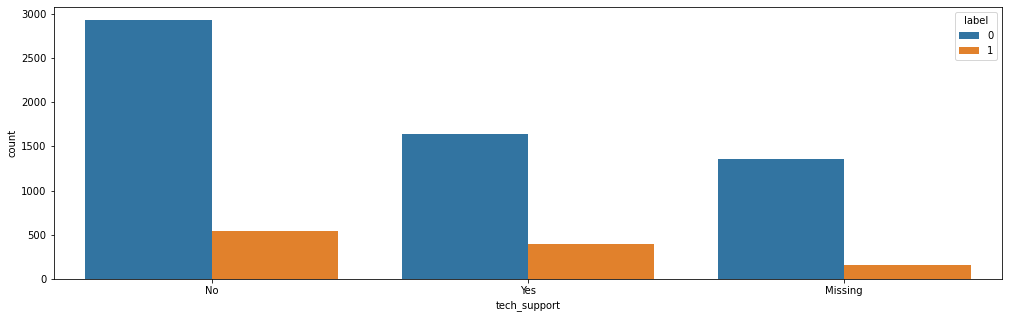

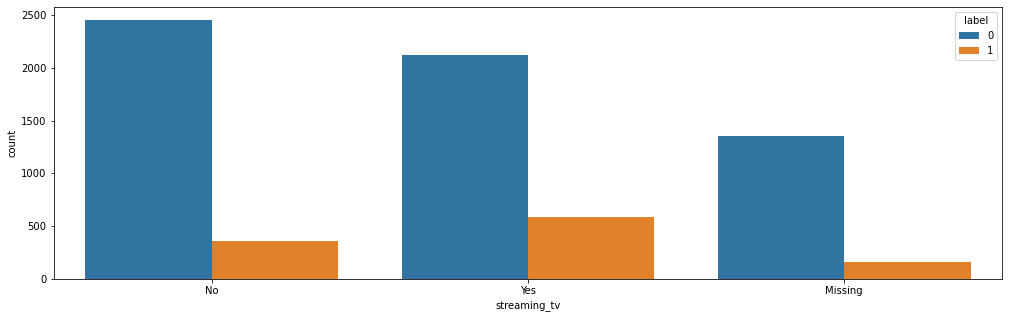

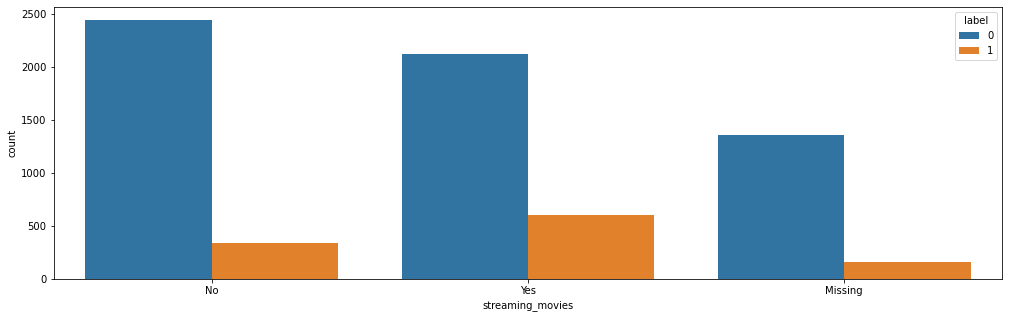

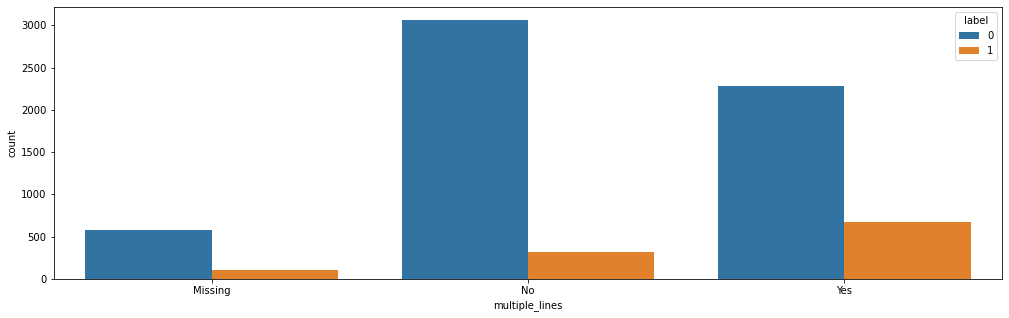

In [36]:
cols_cat = ['gender', 'senior_citizen', 'partner', 'dependents', 'type',
            'paper_less_billing', 'payment_method', 'online_security',
            'online_backup', 'device_protection', 'tech_support',
            'streaming_tv', 'streaming_movies', 'multiple_lines']

# Create a DataFrame with the relevant columns
data_new = data[cols_cat + ['label']]

# Iterate over each categorical column and create a plot
for col in cols_cat:
    plt.figure(figsize=(17, 5))
    sns.countplot(data=data_new, x=col, hue='label')
    plt.show()

Определим наибольшую долю оттока по каждому значению признака

In [37]:
feature = []
result_data = []

for i in data[cols_cat]:
    tab = data[[i, 'label']]
    feature.append(i)
    tab_1 = tab.groupby(i)['label'].mean().reset_index()
    max_label = tab_1['label'].max()
    max_label_rows = tab_1[tab_1['label'] == max_label]
    for index, row in max_label_rows.iterrows():
        result_data.append({'Признак': i, 'Значение': row[i], 'Доля оттока': row['label']})

result_table = pd.DataFrame(result_data)
result_table.sort_values(by = 'Доля оттока', ascending = False)

,Признак,Значение,Доля оттока
8,online_backup,Yes,0.231023
13,multiple_lines,Yes,0.228668
9,device_protection,Yes,0.227555
4,type,Two year,0.226381
12,streaming_movies,Yes,0.221978
11,streaming_tv,Yes,0.216136
2,partner,Yes,0.212032
6,payment_method,Credit card (automatic),0.208553
7,online_security,Yes,0.206058
1,senior_citizen,1.0,0.203152


Таким образом, мы определили по каждому признаку характеристики, которые в большей степени влияют на отток клиентов. В целом, можно сделать следующий вывод, что наименее важным является пол клиента, наиболее важным - online_backup. 

In [38]:
df['begin_date'].min()

Timestamp('2013-10-01 00:00:00')

Самая ранняя дата заключения контракта - 01 октября 2013 года, самая поздяя, как уже говорили выше - дата скачивания анкеты. В чистом виде даты начала и конца не несут смысловой нагрузки, поэтому логично ввести признак - период действия договора в днях

In [39]:
# Создание признака - срок действия договора
df['diff_date'] = (df['end_date'] - df['begin_date']).dt.days.astype('int64')

### Числовые признаки

In [40]:
df['diff_date'].describe().T

count    7028.000000
mean      899.841207
std       682.428205
min        28.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: diff_date, dtype: float64

Максимальный срок действия договора - 2314 дня, минимальное - 28 дней, среднее значение - 900 дней, медианное - 761 день. Наблюдается правостороннее распределение.

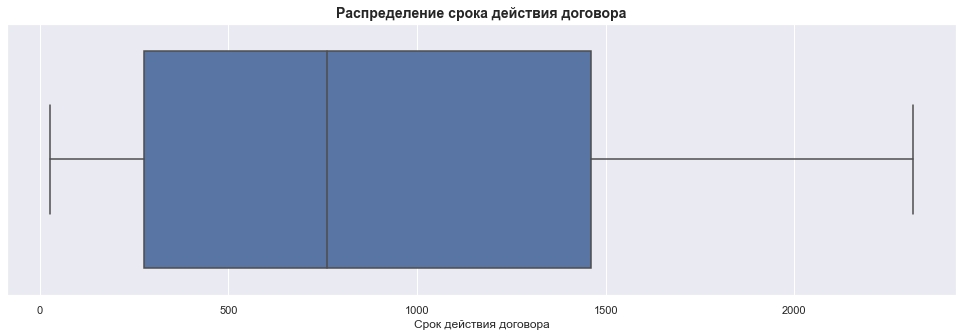

In [41]:
sns.set(rc={'figure.figsize':(17,5)})
pt = sns.boxplot(data=df, x='diff_date')
pt.set_title('Распределение срока действия договора',fontdict= {'fontsize': 14, 'fontweight':'bold'})
pt.set(xlabel='Срок действия договора');

Text(0, 0.5, 'Количество клиентов')

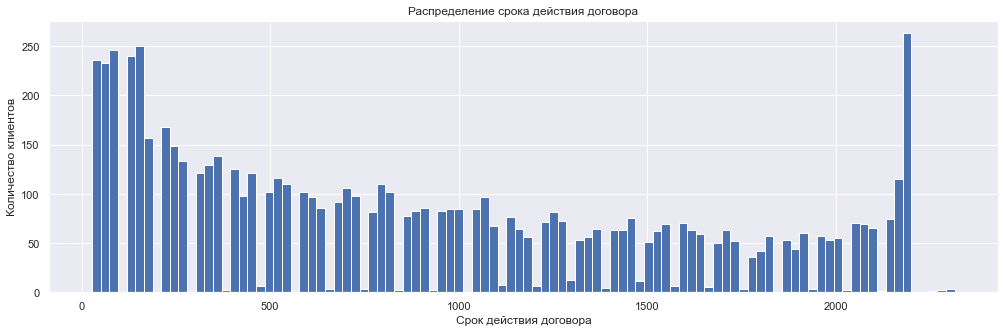

In [42]:
df['diff_date'].hist(bins=100)
plt.title('Распределение срока действия договора')
plt.xlabel('Срок действия договора')
plt.ylabel('Количество клиентов')

Считаю, что этот признак будет полезный для нашей модели. Так как мы его ввели, необходимо избавиться от утечки данных, а именно, удалить признаки, несущие дату начала и дату окончания действия договора.

In [43]:
df = df.drop(['begin_date', 'end_date'], axis=1)

In [44]:
df['monthly_charges'].describe().T

count    7028.000000
mean       64.809555
std        30.075631
min        18.250000
25%        35.650000
50%        70.350000
75%        89.862500
max       118.750000
Name: monthly_charges, dtype: float64

Максимальный ежемесячный платеж 118,75, минимальный - 18,25. Среднее значение платежа - 64,8, медианное - 70,35. Наблюдается левостороннее распределение данных.

Text(0, 0.5, 'Количество клиентов')

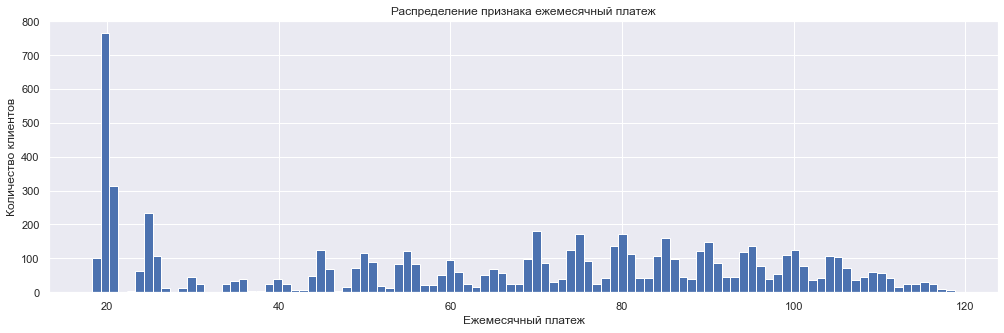

In [45]:
# Визуальное представление распределения признака ежемесячный платеж
df['monthly_charges'].hist(bins=100)
plt.title('Распределение признака ежемесячный платеж')
plt.xlabel('Ежемесячный платеж')
plt.ylabel('Количество клиентов')

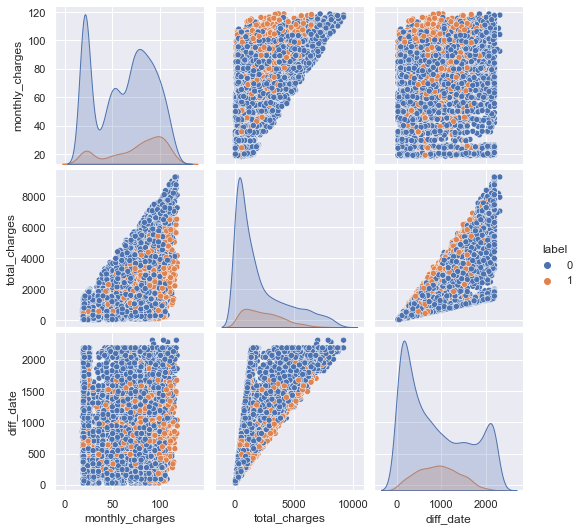

In [46]:
corr_plot = df[['monthly_charges', 'total_charges', 'diff_date','label']]
sns.pairplot(corr_plot, hue='label')

На рисунке хорошо видно, что имеется сильная связь между общими затратами и тем, сколько клиент был в компании, при этом, видно, что чем дольше клиент в компании тем меньше количества уходов. Также имеется зависимость между ежемесячным платежем и общим, а также то, что чем больше ежемесячный платеж, тем больше количество клиентов, ушедших из компании

In [47]:
df['total_charges'].describe().T

count    7028.000000
mean     2118.393320
std      2111.787509
min        19.050000
25%       439.987500
50%      1345.275000
75%      3239.317500
max      9221.380000
Name: total_charges, dtype: float64

Максимальное количество потраченных денег 9221,38, минимальное - 19,05. Среднее значение - 2118,39, медианное - 1345,27. Наблюдается правостороннее распределение данных.

Text(0, 0.5, 'Количество клиентов')

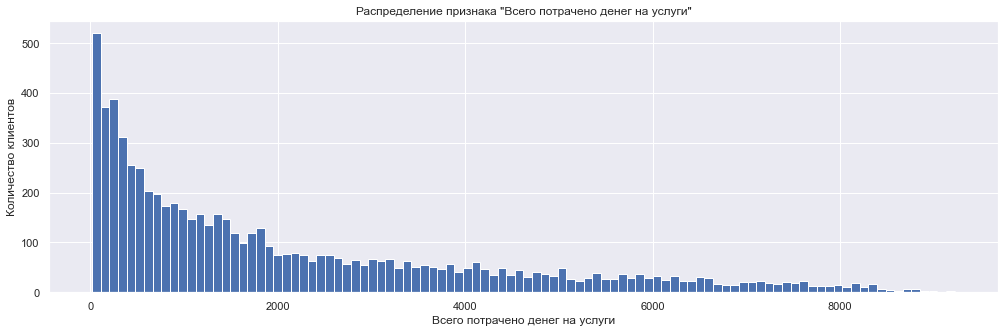

In [48]:
# Визуальное представление распределения признака общие платежи
df['total_charges'].hist(bins=100)
plt.title('Распределение признака "Всего потрачено денег на услуги"')
plt.xlabel('Всего потрачено денег на услуги')
plt.ylabel('Количество клиентов')

In [49]:
corr_matrix = df[['monthly_charges', 'total_charges', 'diff_date']].corr(method='pearson')
corr_matrix.round(2).style.background_gradient('PRGn')

,monthly_charges,total_charges,diff_date
monthly_charges,1.000000,0.630000,0.220000
total_charges,0.630000,1.000000,0.820000
diff_date,0.220000,0.820000,1.000000


In [50]:
phik_matrix = df[['monthly_charges', 'total_charges', 'diff_date']].phik_matrix()
phik_matrix.round(2).style.background_gradient('PRGn')

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'diff_date']


,monthly_charges,total_charges,diff_date
monthly_charges,1.000000,0.710000,0.390000
total_charges,0.710000,1.000000,0.850000
diff_date,0.390000,0.850000,1.000000


Полученные коэффициенты корреляции между сроком договора, ежемесячными и общими платежами, говорят, что имееется сильная связь между сроком договора и общими платежами, а также чуть менее сильная связь между ежемесячными и общими платежами. На основе этого, считаю целесообразным, убрать признак с общими платежами с целью уменьшения признакового пространства.

In [51]:
df = df.drop('total_charges', axis=1)

<AxesSubplot:>

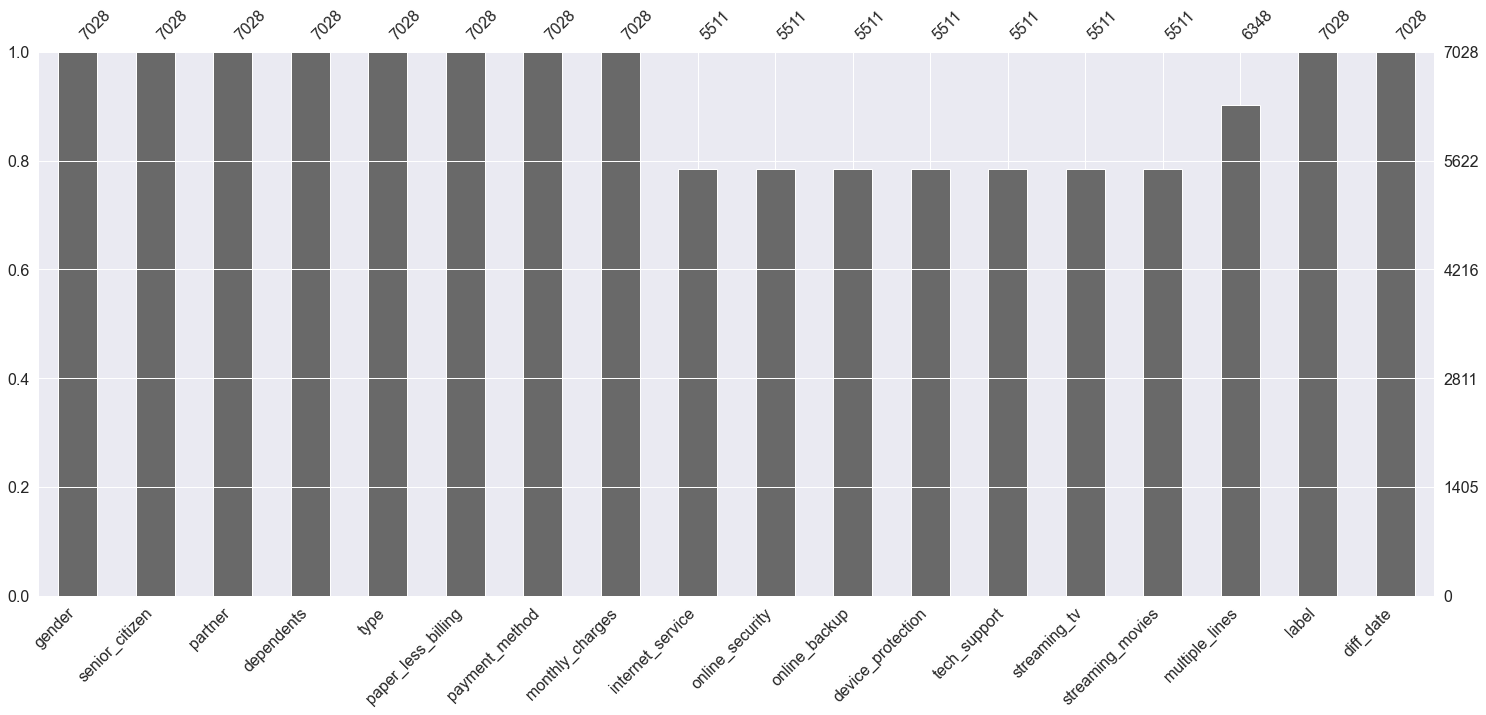

In [52]:
# Визуальное представление пропусков в датасете
msno.bar(df)

Хорошо видно, что основные пропуски в сервисах Интернет, что логично, так как каждый пользователь подключал только требуемые ему услуги, а также в признаке телефонная связь (ранее было установлено, что не некоторые пользователи не пользуются телефонной связью, а заключили договор только на услуги Интернета). Логично, что если значение пропущено, значит клиент не пользуется услугой. Заполнениим пропуски значением 'No'.

In [53]:
df = df.fillna('No')

Так как у нас бинароное значение признака senior_citizen, но он является категориальным, заменим значенния 1 и 0 на  'Yes', 'No' соответственно

In [54]:
df['senior_citizen'] = df['senior_citizen'].replace({1: 'Yes', 0: 'No'})

In [55]:
# Матрица phik-корреляции для всех признаков
phik_overview = df.phik_matrix(interval_cols = ['monthly_charges', 'diff_date'])
phik_overview.round(2).style.background_gradient('PRGn')

,gender,senior_citizen,partner,dependents,type,paper_less_billing,payment_method,monthly_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,label,diff_date
gender,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.020000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000
senior_citizen,0.000000,1.000000,0.020000,0.320000,0.090000,0.240000,0.290000,0.300000,0.160000,0.060000,0.100000,0.090000,0.090000,0.160000,0.190000,0.220000,0.090000,0.060000
partner,0.000000,0.020000,1.000000,0.650000,0.180000,0.010000,0.240000,0.200000,0.000000,0.220000,0.220000,0.240000,0.190000,0.190000,0.180000,0.220000,0.230000,0.450000
dependents,0.000000,0.320000,0.650000,1.000000,0.150000,0.170000,0.220000,0.180000,0.110000,0.120000,0.030000,0.010000,0.100000,0.020000,0.060000,0.030000,0.050000,0.200000
type,0.000000,0.090000,0.180000,0.150000,1.000000,0.110000,0.280000,0.390000,0.500000,0.150000,0.100000,0.140000,0.180000,0.070000,0.070000,0.070000,0.090000,0.640000
paper_less_billing,0.000000,0.240000,0.010000,0.170000,0.110000,1.000000,0.370000,0.470000,0.230000,0.000000,0.200000,0.160000,0.050000,0.340000,0.320000,0.250000,0.080000,0.020000
payment_method,0.000000,0.290000,0.240000,0.220000,0.280000,0.370000,1.000000,0.400000,0.320000,0.260000,0.280000,0.310000,0.270000,0.380000,0.380000,0.340000,0.210000,0.350000
monthly_charges,0.010000,0.300000,0.200000,0.180000,0.390000,0.470000,0.400000,1.000000,0.920000,0.550000,0.630000,0.670000,0.580000,0.840000,0.830000,0.680000,0.230000,0.390000
internet_service,0.000000,0.160000,0.000000,0.110000,0.500000,0.230000,0.320000,0.920000,1.000000,0.240000,0.230000,0.230000,0.240000,0.270000,0.270000,0.230000,0.060000,0.060000
online_security,0.020000,0.060000,0.220000,0.120000,0.150000,0.000000,0.260000,0.550000,0.240000,1.000000,0.430000,0.420000,0.530000,0.270000,0.290000,0.150000,0.130000,0.390000


Матрица фик-корреляции показала, что сильная связь имеется между ежемесячными платежами и признаком internet_service (0,95). Это логично, так как именно за эти услуги платит клиент. Так как у нас есть отдельные признаки, входящие по интернет-услугам, удалим признак internet_service. Признаков, сильно влияющих на тергет, не обнаружено.

In [56]:
df = df.drop('internet_service', axis=1)

### Целевой признак 

Text(0, 0.5, 'Количество клиентов')

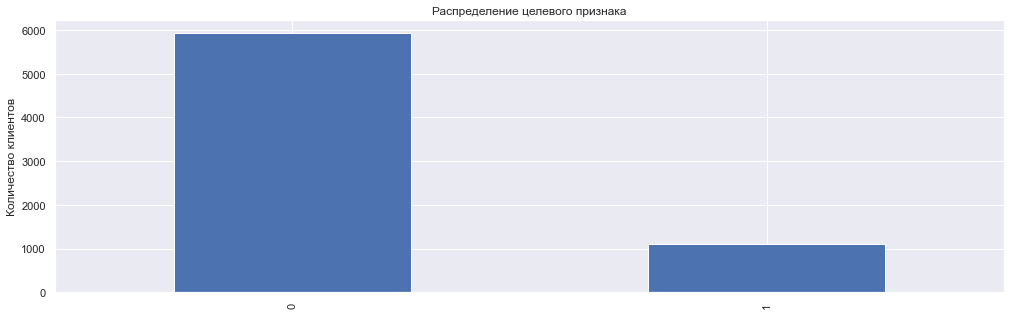

In [57]:
df['label'].value_counts().plot(kind='bar')
plt.title('Распределение целевого признака')
plt.ylabel('Количество клиентов')

Ярко выраженный дисбаланс классов, не смотря на то, что наша метрика не чувствительна к дисбалансу,будем это иметь ввиду при моделировании

Таким образом, анализ показал, что: оттоку способствуют такие признаки как: подключенная услуга online_backup, выделение multiple_lines, device_protection, тип оплаты на 2 года, подключенное стриминговое телевидение и фильмы, наличие супруга(и), в целевом признаке наблюдается существенный дисбаланс классов: на долю оттока приходится всего 15,6% данных.

## Обучение моделей

### Определим выборки для обучения моделей

In [58]:
features = df.drop('label', axis = 1)
target = df['label']

Разобъем датасет на тренировочную и тестовую выборки в соотношении 75-25

In [59]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, stratify = df['label'], random_state=RANDOM_STATE)

In [60]:
len(target_test)/len(target)

0.25

Данные разбиты корректно

### Создание pipeline для подготовки данных

Определим категориальные и числовые признаки

In [61]:
cat_cols = features_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = features_train.select_dtypes(exclude=["object"]).columns.tolist()

In [62]:
cat_cols

['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'type',
 'paper_less_billing',
 'payment_method',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

In [63]:
num_cols

['monthly_charges', 'diff_date']

In [64]:
preprocessing = ColumnTransformer(
    transformers=[("encoder", OneHotEncoder(drop='first'), cat_cols)]
)

### RandomForestClassifier

In [65]:
# Полный pipeline для RandomForestClassifier
full_pipe_rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("regressor", RandomForestClassifier(random_state=RANDOM_STATE)),
    ]
)

In [66]:
%%time

parameters_rf = {
    'regressor__n_estimators': range(50, 100, 5),
    'regressor__max_depth': range(2, 10),
    'regressor__class_weight': ['balanced', None]
}

search_rf = GridSearchCV(full_pipe_rf , parameters_rf, cv=4, scoring='roc_auc')
search_rf.fit(features_train, target_train)

# Печатаем лучшие значения метрики и гиперпараметры
print('AUC-ROC для RandomForestClassifier:', '%.4f' %search_rf.best_score_)

print(pd.Series(search_rf.best_params_))

AUC-ROC для RandomForestClassifier: 0.7122
regressor__class_weight    balanced
regressor__max_depth              5
regressor__n_estimators          80
dtype: object
CPU times: total: 2min 27s
Wall time: 2min 27s


### CatBoostClassifier

In [67]:
%%time
param_grid_cat = {
    'learning_rate': optuna.distributions.FloatDistribution(0.1, 0.3, step=0.05),
    'depth': optuna.distributions.IntDistribution(2, 10, step=1),
    'scale_pos_weight': optuna.distributions.FloatDistribution(1, 6)
}

cat_model = CatBoostClassifier(logging_level = "Silent", eval_metric='AUC', cat_features=cat_cols, random_state=RANDOM_STATE)

search_cv_cat = OptunaSearchCV(estimator=cat_model,
                               param_distributions=param_grid_cat,
                               scoring='roc_auc',
                               verbose=20,
                               n_jobs=-1,
                               n_trials=20,
                               cv=4,
                               random_state=RANDOM_STATE)

search_cv_cat.fit(features_train, target_train)

print('roc_auc', search_cv_cat.best_score_)
print(pd.Series(search_cv_cat.best_params_))

<timed exec>:9: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-06-04 00:53:51,564] A new study created in memory with name: no-name-ff0a89fa-7919-4fc1-9bed-f6bf03bf4d5c
[I 2023-06-04 00:53:51,565] Searching the best hyperparameters using 5271 samples...
[I 2023-06-04 00:55:30,128] Trial 7 finished with value: 0.925267834504243 and parameters: {'learning_rate': 0.2, 'depth': 2, 'scale_pos_weight': 3.3465594736309563}. Best is trial 7 with value: 0.925267834504243.
[I 2023-06-04 00:55:45,671] Trial 1 finished with value: 0.9218952125929877 and parameters: {'learning_rate': 0.15000000000000002, 'depth': 2, 'scale_pos_weight': 1.0700014823324224}. Best is trial 7 with value: 0.925267834504243.
[I 2023-06-04 00:56:15,077] Trial 6 finished with value: 0.918975305585668 and parameters: {'learning_rate': 0.2, 'depth': 3, 'scale_pos_weight': 5.763139140450063}. Best is trial 7 with value: 0.925267834504243.
[I 2023-0

roc_auc 0.925267834504243
learning_rate       0.200000
depth               2.000000
scale_pos_weight    3.346559
dtype: float64
CPU times: total: 1h 22min 57s
Wall time: 14min 41s


### LGBMClassifier

In [68]:
features_train_cat = features_train.copy()
features_test_cat = features_test.copy()

In [69]:
for col in cat_cols:
    features_train_cat[col] = features_train[col].astype('category')
    features_test_cat[col] = features_test[col].astype('category')

In [70]:
%%time
param_grid_lgbm = {
    'learning_rate': optuna.distributions.FloatDistribution(0.1, 0.3, step=0.05),
    'max_depth': optuna.distributions.IntDistribution(2, 10, step=1),
    'scale_pos_weight': optuna.distributions.FloatDistribution(1, 6)
}

lgbm_model = lgb.LGBMClassifier(random_state=RANDOM_STATE)
search_cv_lgbm = OptunaSearchCV(estimator=lgbm_model,
                               param_distributions=param_grid_lgbm,
                               scoring='roc_auc',
                               n_jobs=-1,
                               cv=4,
                               random_state=RANDOM_STATE)

search_cv_lgbm.fit(features_train_cat, target_train)

print('roc_auc', search_cv_lgbm.best_score_)
print(pd.Series(search_cv_lgbm.best_params_))

<timed exec>:8: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-06-04 01:08:33,642] A new study created in memory with name: no-name-c423b38d-b9b3-470b-b118-7e2fa6b91c6e
[I 2023-06-04 01:08:34,559] Trial 1 finished with value: 0.836146055589085 and parameters: {'learning_rate': 0.1, 'max_depth': 2, 'scale_pos_weight': 4.020550817357497}. Best is trial 1 with value: 0.836146055589085.
[I 2023-06-04 01:08:34,707] Trial 0 finished with value: 0.8783215168712816 and parameters: {'learning_rate': 0.3, 'max_depth': 3, 'scale_pos_weight': 5.190258054365464}. Best is trial 0 with value: 0.8783215168712816.
[I 2023-06-04 01:08:34,764] Trial 3 finished with value: 0.8615623328995974 and parameters: {'learning_rate': 0.2, 'max_depth': 3, 'scale_pos_weight': 5.734699884820603}. Best is trial 0 with value: 0.8783215168712816.
[I 2023-06-04 01:08:35,802] Trial 6 finished with value: 0.869055159255589 and parameters: {'lear

roc_auc 0.8787757641550801
learning_rate       0.250000
max_depth           8.000000
scale_pos_weight    1.372176
dtype: float64
CPU times: total: 16.8 s
Wall time: 2.83 s


Мы провели обучение 3 моделей: RandomForestClassifier, CatBoostClassifier и LGBMClassifier. Гиперпараметры подбирали с помощью Optuna. Наилучший результат у модели CatBoost, будем ее использовать при тестировании.

## Тестирование модели

In [71]:
#Рассчитаем вероятность 1 класса
test_pred_proba = search_cv_cat.best_estimator_.predict_proba(features_test)[:, 1]
# рассчитаем roc_auc_score
auc_test = roc_auc_score(target_test, test_pred_proba)
# предскажем значения
test_pred = search_cv_cat.best_estimator_.predict(features_test)
# рассчитаем accuracy
accuracy = accuracy_score(target_test, test_pred)

print('roc_auc:', auc_test)
print('Accuracy:', accuracy)

roc_auc: 0.9434535639798798
Accuracy: 0.9174729652817302


При тестировании модели мы получили очень хороший результат: roc_auc = 0.94 (модель одинаково хорошо определяет положительный и отрицательный класс), при техзадании (не менее 0,85). Это также подтверждает Accuracy = 0.91 (правильный класс определяется примерно для 91% данных)

In [72]:
fpr, tpr, thresholds = roc_curve(target_test, test_pred_proba)

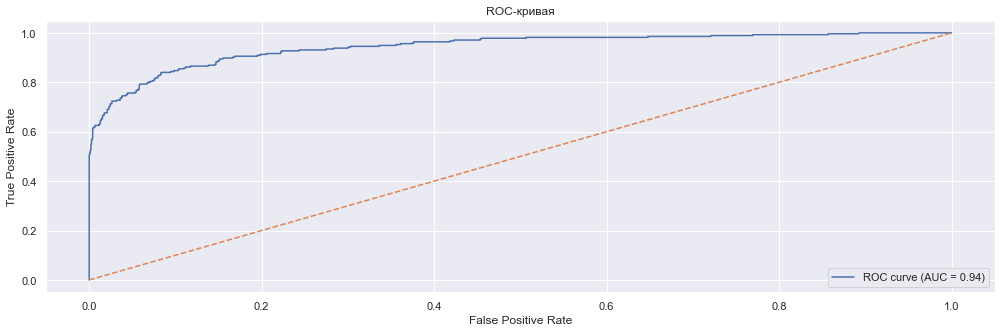

In [73]:
# Графическое изображение Рок-кривой
plt.figure(figsize=(17, 5))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_test)
plt.plot([0, 1], [0, 1], linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.show()

Диагональ на рисунке показывает значения случайного классификатора (проверка на адекватность модели)

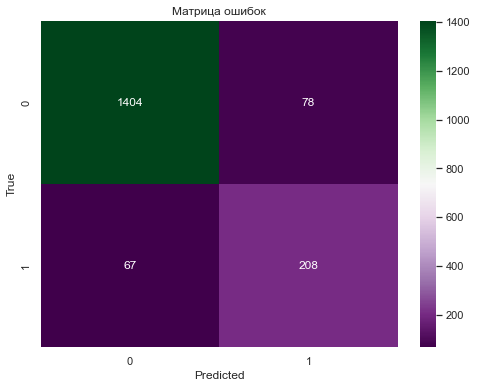

In [74]:
confusion_mat = confusion_matrix(target_test, test_pred)

# PГрафическое изображение матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='PRGn')
plt.title('Матрица ошибок')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Наша модель верно предсказала 1404 значения - что не уйдет человек и 208 - что уйдет. У 78 значений модель предсказала, что человек уйдет, а на самом деле он не ушел (это может дать компании дополнительные затраты при удержании этих клиентов). В 67 случаев модель ошиблась и не определила клиентов, которые ушли.

Определим важность признаков. В модели Кэтбуст есть встроенная функция, воспользуемся ей

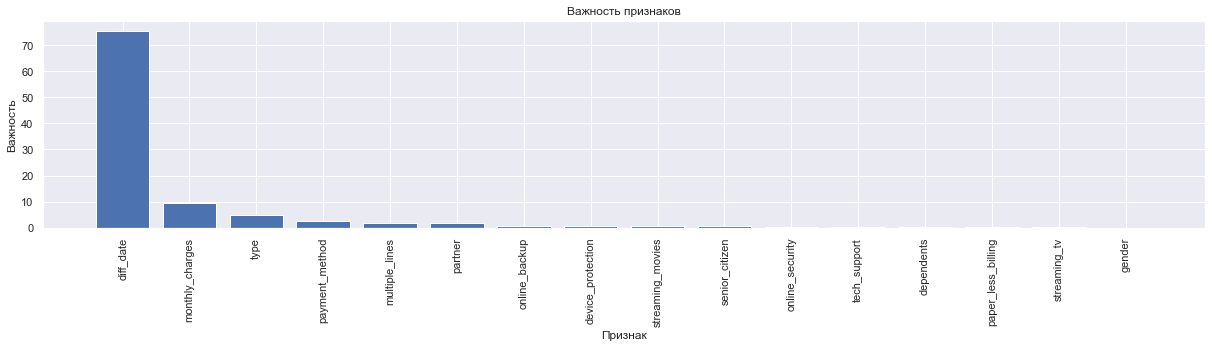

In [75]:
# Определим значения важности признаков
feature_importances = search_cv_cat.best_estimator_.feature_importances_
# Названия признаков
feature_names = list(features_train.columns)
#Отсортируем по индексам значения важности признаков
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
# Соотнесем отсортированные значения важности и названия признаков
sorted_feature_names = [feature_names[i] for i in sorted_indices]

#Графическое изображение важности признаков
plt.figure(figsize=(17, 5))
plt.bar(range(len(sorted_feature_importances)), sorted_feature_importances)
plt.xticks(range(len(sorted_feature_importances)), sorted_feature_names, rotation=90)
plt.xlabel('Признак')
plt.ylabel('Важность')
plt.title('Важность признаков')
plt.tight_layout()
plt.show()

Наиболее важным признаком является - время, сколько человек является клиентом, на втором месте - ежемесячные платежи, на 3 - тип оплаты (помесячная, на год-два). Остальные признаки менее значительны. Это может дать основу для формирования маркетинговой стратегии, основанной на удержании клиента за счет снижения платежа, при заключении долгосрочного договора. 

# Вывод

<p>Перед нами стояла задача прогнозирования оттока клиентов целью разработки предложений (промокодов и специальных условий), направленных на их удержание.
Компания предоставляет 2 основных типа услуг: Стационарную телефонную связь и Интернет.
В нашем распоряжении имелись 4 таблицы, содержащие информацию о договоре, персональных данных клиента, об интернет-услугах, об услугах телефонии, все таблицы связаны по ключу – уникальный идентификатор пользователя.
<p><b>Первичный осмотр данных</b> показал, что датасет contract представлен 7043 строками - id уникальных пользователей. Пропущенных значений нет; в столбце дата окончания есть значение 'no', что означает, что клиент еще не ушел; все столбцы, кроме ежемесячного платежа в формате object. Строки-дубликаты отсутствуют. 
Датасет persona представлен 7043 строками - id уникальных пользователей. Пропущенных значений нет; все столбцы, кроме пенсионного статуса в формате object. Строки-дубликаты отсутствуют. 
Датасет internet представлен 5517 строками - id уникальных пользователей. Надо отметить, что это меньшее количество, чем в таблице с контрактами, следовательно, не все пользователи подключили интернет. Пропущенных значений нет; все столбцы имеют тип данных object.
Датасет phone представлен 6361 строками - id уникальных пользователей. Надо отметить, что это меньшее количество, чем в таблице с контрактами и интернетом, следовательно, не все пользователи имеют стационарную телефонную связь. Как и в предыдущих датасетах; пропущенных значений нет; строк-дубликатов нет; столбцы имеют тип данных object..

<p>Далее была выполнена <b>первичная предобработка данных</b>.
<p>1) Объединили 4 таблицы в одну. Получили 19 признаков, пропущенные значения в столбцах с признаками, относящимся к интернету или телефонии; обнаружилось 4 дубликата - пользоватлели, имеющие одинаковые характеристики, хотя это разные люди, для моделирования удалили их.
<p>2) Привели заголовки столбцов к «змеиному» регистру для удобства.
<p>3) Добавили целевой признак: ушел клиент (1) или нет( 0) н на момент скачивания данных.
<p>4) Клиенты с незаполненным значением total_charges заключили договор в день скачивания анкеты, у всех контракт на 2 года, ежемесячный платеж осуществлен. Можно было бы заполнить пропущенные значения значением ежемесячного платежа, однако, это всего 11 пользователей, которые к тому же, только пришли, и заключили долгосрочный контракт, удалили их, так как информативности при моделировании от них немного (и их незначительное количество). Тип данных столбца "TotalCharges" изменили на float.
<p>5) изменили тип данных в столбцах со временем начала и окончания договора.

<p>Результаты <b>разведывательного анализа данных</b>.
<p>1)	Соотношение клиентов-мужчин и женщин практически одинаковое. Около 16% клиентов-пенсионеров; 48% людей имеют супруга(у). Большая часть (70%) клиентов не обременена иждивенцами. Более половины (55%) используют ежемесячный тип оплаты, договоры на два года и на год заключают примерно одинаковое количество людей (24% и 21%). Электронный платежный документ получает 59% клиентов, среди доминирующего способа оплаты можно выделить Electronic check (34%), остальные имеют равную долю (22-23%). У клиентов, подключивших Интернет (их 78%), преобладающий тип соединения – оптоволокно (44%), услуга по блокировке небезопасных сайтов подключена только у 29% , облачное хранилище данных – у 34%, антивирус – также у 34% . Выделенную линию техподдержки имеют 29% клиентов, стриминговое телевидение – у 38%, каталог фильмов – у 39% клиентов, наличие ведения параллельных линий во время звонка – у 42%.
<p>2)	При рассмотрении доли оттока по значениям признаков, определили, что наибольшая доля у клиентов, использующих услуги: online_backup (23,1%), multiple_lines (22,86%), device_protection (22,75%), а также тип оплаты – на два года (22,63%). 
<p>3)	Так как в чистом виде даты начала и конца действия договора не несут смысловой нагрузки, нами был рассчитан и добавлен новый признак «период действия договора в днях» (diff_date). Так как мы его ввели, чтобы избавиться от утечки данных, удалили признаки, несущие дату начала и дату окончания действия договора.
<p>4)	Было установлено, что максимальный срок действия договора - 2314 дня, минимальное - 28 дней, среднее значение - 900 дней, медианное - 761 день. Наблюдается правостороннее распределение.
<p>5)	Максимальный ежемесячный платеж 118,75, минимальный - 18,25. Среднее значение платежа - 64,8, медианное - 70,35. Наблюдается левостороннее распределение данных. Максимальное количество потраченных денег 9221,38, минимальное - 19,05. Среднее значение - 2118,39, медианное - 1345,27. Наблюдается правостороннее распределение данных.
<p>6)	Было установлено, что имеется сильная связь между общими затратами и тем, сколько клиент был в компании, при этом, видно, что чем дольше клиент в компании, тем меньше количества уходов. Также имеется зависимость между ежемесячным платежем и общим, а также то, что чем больше ежемесячный платеж, тем больше количество клиентов, ушедших из компании. В связи с этим, мы удалили признак с общими платежами с целью уменьшения признакового пространства.
<p>7)	Пропущенные значения в признаках, связанных с Интернетом и телефонией решили заполнить значением «No».
<p>8)	Так как у нас бинароное значение признака senior_citizen, но он является категориальным, заменили значенния 1 и 0 на 'Yes', 'No' соответственно.
<p>9)	Матрица фик-корреляции показала, что сильная связь имеется между ежемесячными платежами и признаком internet_service (0,95). Это логично, так как именно за эти услуги платит клиент. Так как у нас есть отдельные признаки, входящие по интернет-услугам, удалили признак internet_service.
<p>10)	Ярко выраженный дисбаланс классов по целевому признаку, на долю оттока приходится всего 15,6% данных. Несмотря на то, что метрика AUC-ROC не чувствительна к дисбалансу, при подборе гиперпараметров, рассмотрим варианты: без баланса и с ним. 

<p><b>Моделирование</b>
<p>Разбили данные на тренировочную и тестовую выборки.Определили признаки для обучения: категориальные ('gender', 'senior_citizen', 'partner', 'dependents', 'type', 'paper_less_billing', 'payment_method',
 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines') и числовые ('monthly_charges', 'diff_date'). 
<p>В качестве моделей для обучения решили использовать 3 модели: RandomForestClassifier, CatBoostClassifier, LGBMClassifier. 

<p>Для модели RandomForestClassifier был создан пайплайн для предварительного кодирования. Так как данных не очень много, решили взять OneHotEncoder. Для подбора гиперпараметров использовали GridSearchCV. Гиперпараметры ('n_estimators': range(50, 100, 5), 'max_depth': range(2, 10), 'class_weight': ['balanced', None]). Модель показала неудовлетворительный результат - AUC-ROC для RandomForestClassifier: 0.7122, при гиперпараметрах (regressor__class_weight - balanced, regressor__max_depth – 5, regressor__n_estimators – 80).

<p>Для подбора гиперпараметров для модели CatBoostClassifier использовали Optuna. Гиперпараметры ('learning_rate' (0.1, 0.3, step=0.05), 'depth' (2, 10, step=1), 'scale_pos_weight' (1, 6)). Модель показала на тренировочной выборке хороший результат - 0.9223 с гиперпараметрами (learning_rate - 0.150000, depth - 2.000000, scale_pos_weight - 2.146398).

<p>Для подбора гиперпараметров для модели LGBMClassifier использовали также Optuna. Гиперпараметры ('learning_rate' (0.1, 0.3, step=0.05), 'max_depth' (2, 10, step=1), 'scale_pos_weight' (1, 6)). Результа получился хуже, чем у CatBoostClassifier, но лучше, чем у модели RandomForestClassifier - 0.8788 с гиперпараметрами: learning_rate - 0.20000, max_depth - 4.00000, scale_pos_weight - 1.55883.
Таким образом, для тестирования мы выбрали модель CatBoostClassifier. На тесте модель показала очень хороший результат: roc_auc = 0.94 (модель одинаково хорошо определяет положительный и отрицательный класс), при техзадании (не менее 0,85). Это также подтверждает Accuracy = 0.93 (правильный класс определяется примерно для 93% данных).

<p>Построили ROC-кривую, для сравнения со случайным классификатором (проверка на адекватность модели).

<p>При построении матрицы ошибок, установили, что наша модель верно предсказала 1449 значения - что не уйдет человек и 197 - что уйдет. У 33 значений модель предсказала, что человек уйдет, а на самом деле он не ушел (это может дать компании дополнительные затраты при удержании этих клиентов). В 78 случаев модель ошиблась и не определила клиентов, которые ушли.

<p>Оценка важности признаков показала, что наиболее важным признаком является - время, сколько человек является клиентом, на втором месте - ежемесячные платежи, на 3 - тип оплаты (помесячная, на год-два). Остальные признаки менее значительны. Это может дать основу для формирования маркетинговой стратегии, основанной на удержании клиента за счет снижения платежа, при заключении долгосрочного договора.

<p>Таким образом, наша модель соответствует заявленным критериям. Полученная информация о важности признаков должна лечь в основу разработки тарифов и маркетинговых мероприятий по удержанию и привлечению клиентов. Например, скидка, при заключении договора на два и более года, бесплатные дополнительные услуги для постоянных клиентов и др.